# Tutorial 9: Multitable 


In this tutorial, we will execute the avatarization of a multi-table dataset. If you want to know more about how the anonymization is performed, you can read [this page](https://docs.octopize.io/docs/understanding/multi_table/).


### Setup

In [1]:
import numpy as np
import pandas as pd
import io

import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import os

url = os.environ.get("AVATAR_BASE_URL")
username = os.environ.get("AVATAR_USERNAME")
password = os.environ.get("AVATAR_PASSWORD")

# This is the client that you'll be using for all of your requests
from avatars.client import ApiClient
from avatars.models import AvatarizationJobCreate, AvatarizationParameters, PrivacyMetricsMultiTableJobCreate, AvatarizationMultiTableJobCreate, BasePrivacyMetricsParameters
from avatars.models import ReportCreate,SignalMetricsJobCreate,SignalMetricsParameters
from avatars.models import TableReference, TableLink, PrivacyMetricsParameters, PrivacyMetricsMultiTableParameters, AvatarizationMultiTableParameters,BasePrivacyMetricsParameters,BaseAvatarizationParameters

# Change this to your actual server endpoint, e.g. base_url="https://avatar.company.com"
client = ApiClient(base_url=url)
client.authenticate(username=username, password=password)

# Verify that we can connect to the API server
client.health.get_health()

{'message': 'ok'}

## Loading data

In this tutorial, we will avatarise data that contains a patient table, a doctor table and a visit table 
- There are 130 patients having at least 1 visit
- There are 50 doctors, they all did at least one visit 
- There are 300 visits

Note: 
- Each table has a primary key with only unique values
- Each child table refers to a parent table using a foreign key

<img src="img/multitable.png" style="height:500px" />

In [2]:
doctor = pd.read_csv("../fixtures/doctor.csv", sep=",")
patient = pd.read_csv("../fixtures/patient.csv", sep=",")
visit = pd.read_csv("../fixtures/visit.csv", sep=",")

In [3]:
patient.head()

,p_id,gender,height,age,weight
0,0,Female,143.548913,72.151503,48.373323
1,1,Female,168.379863,75.245786,64.936355
2,2,Female,163.936152,68.709763,63.023700
3,3,Female,144.498306,69.477118,33.869671
4,4,Female,162.280781,64.343092,45.117277


In [4]:
doctor.head()

,d_id,job,age
0,0,pediatrician,36.374378
1,1,pediatrician,34.312795
2,2,pediatrician,40.288084
3,3,pediatrician,44.212885
4,4,pediatrician,38.885413


In [5]:
visit.head()

,visit_id,patient_id,doctor_id,day_visit,exam
0,0,86,29,Tuesday,routine_check
1,1,10,4,Tuesday,pediatrics
2,2,101,37,Wednesday,routine_check
3,3,108,39,Friday,vaccine
4,4,113,40,Wednesday,vaccine


## Upload data
First we need to upload each table in the database.
Each id column name MUST be specified in the `identifier_variables` parameter

Note: 
- A table with no ancestor has only 1 id variable (primary key)
- Any other table has 1 id variable per link with a parent table (foreign key) + its primary key.

In [6]:
dataset_patient = client.pandas_integration.upload_dataframe(
    patient,
    name="patient",
    identifier_variables=[
        "p_id",
    ],
)

dataset_doctor = client.pandas_integration.upload_dataframe(
    doctor,
    name="doctor",
    identifier_variables=[
        "d_id",
    ],
)

dataset_visit = client.pandas_integration.upload_dataframe(
    visit,
    name="visit",
    identifier_variables=["visit_id", "patient_id", "doctor_id"],
)

## Parameters setup
Once the tables have been uploaded, you need to specify which ones are at individual level.

Note:
- An individual level table is a dataframe where each row refers to a UNIQUE physical individual. Privacy metrics assess the re-identification risk of these individuals.
- A table with no ancestor must be at individual level.

In [7]:
patient_ref = TableReference(
    dataset_id=dataset_patient.id,
    is_individual_level=True,
)

doctor_ref = TableReference(
    dataset_id=dataset_doctor.id,
    is_individual_level=True,
)

visit_ref = TableReference(
    dataset_id=dataset_visit.id,
    is_individual_level=False,
)

Finally, before proceeding to anonymization, you need to specify the links between each table, as well as the anonymization parameters for each table.

Note:
- A link is a relation between 1 parent table and 1 child table

In [8]:
table_links = [
    TableLink(
        parent_table=patient_ref,
        child_table=visit_ref,
        link_method="bottom_projection",
        parent_link_key="p_id",
        child_link_key="patient_id",
    ),
    TableLink(
        parent_table=doctor_ref,
        child_table=visit_ref,
        link_method="bottom_projection",
        parent_link_key="d_id",
        child_link_key="doctor_id",
    ),
]

# The k parameter for each table needs to be adjusted regarding the number of records.
avat_parameters = [
        BaseAvatarizationParameters(dataset_id=dataset_patient.id, k=15),
        BaseAvatarizationParameters(dataset_id=dataset_doctor.id, k=5),
        BaseAvatarizationParameters(dataset_id=dataset_visit.id, k=30),
]

## Anonymization

In [9]:

avat_job = client.jobs.create_avatarization_multi_table_job(
    AvatarizationMultiTableJobCreate(
        parameters=AvatarizationMultiTableParameters(
            table_links=table_links, table_parameters=avat_parameters
        )
    )
)

avat_job = client.jobs.get_avatarization_multi_table_job(avat_job.id)
results = avat_job.result.datasets

# Get back avatar tables from the results

#Patient
patient_avatar_id = results[0].avatars_dataset.id
patient_avatar = client.pandas_integration.download_dataframe(
    patient_avatar_id
)
# Doctor
doctor_avatar_id = results[1].avatars_dataset.id
doctor_avatar = client.pandas_integration.download_dataframe(
    doctor_avatar_id
)

# Visit
visit_avatar_id = results[2].avatars_dataset.id
visit_avatar = client.pandas_integration.download_dataframe(
    visit_avatar_id
)
    

In [10]:
patient_avatar.head()

,p_id,gender,height,age,weight
0,16,Female,162.361700,64.271716,52.272057
1,111,Male,176.784058,59.699222,82.518153
2,34,Female,149.353783,65.934724,41.516113
3,93,Female,163.372354,70.639848,58.480239
4,31,Female,160.000919,66.397664,59.317126


In [11]:
doctor_avatar.head()

,d_id,job,age
0,38,general practitioner,55.183481
1,34,general practitioner,50.821945
2,19,general practitioner,49.962461
3,20,general practitioner,52.942279
4,6,general practitioner,49.947762


In [12]:

visit_avatar.head()

,visit_id,patient_id,doctor_id,day_visit,exam
0,138,0,25,Monday,routine_check
1,143,1,46,Thursday,routine_check
2,252,1,37,Wednesday,routine_check
3,94,1,45,Friday,routine_check
4,34,1,42,Friday,routine_check


## Privacy metric computation
Similarly to multitable avatarization, privacy metrics calculation requires the specification of one set of parameter per table. 

In [13]:
privacy_parameters = parameters = [
    BasePrivacyMetricsParameters(
        original_id=results[0].original_id,
        unshuffled_avatars_id=results[0].sensitive_unshuffled_avatars_datasets.id,
        closest_rate_percentage_threshold=0.3,
        closest_rate_ratio_threshold=0.3,
        known_variables=[
            "gender",
            "age",
        ],
        target="weight",
    ),
    BasePrivacyMetricsParameters(
        original_id=results[1].original_id,
        unshuffled_avatars_id=results[1].sensitive_unshuffled_avatars_datasets.id,
        closest_rate_percentage_threshold=0.3,
        closest_rate_ratio_threshold=0.3,
        known_variables=[
            "age",
        ],
        target="job",
    ),
    BasePrivacyMetricsParameters(
        original_id=results[2].original_id,
        unshuffled_avatars_id=results[2].sensitive_unshuffled_avatars_datasets.id,
    ),
]

privacy_job = client.jobs.create_privacy_metrics_multi_table_job(
    PrivacyMetricsMultiTableJobCreate(
        parameters=PrivacyMetricsMultiTableParameters(
            table_links=table_links,
            table_parameters=privacy_parameters,
        )
    )
)

privacy_job = client.jobs.get_privacy_metrics_multi_table_job(privacy_job.id)


In [14]:
# You can run this line again if the job is still pending (default timeout = 60 seconds)
privacy_job = client.jobs.get_privacy_metrics_multi_table_job(privacy_job.id)

## Privacy metric results
The privacy metrics results are computed on multiple tables to verify as many attack scenario as possible.

All types of multi table privacy scenario are further described [here](https://docs.octopize.io/docs/understanding/multi_table/).

<img src="img/multitable_privacy.png" style="height:500px" />

## RAW results

In [15]:
privacy_metrics = privacy_job.result.details
print("*** Privacy metrics ***")
for metric in privacy_metrics:
    print('--------')
    print(metric)

*** Privacy metrics ***
--------
hidden_rate=82.0 local_cloaking=2.0 distance_to_closest=0.01295 closest_distances_ratio=0.3279 column_direct_match_protection=96.0 categorical_hidden_rate=100.0 row_direct_match_protection=100.0 correlation_protection_rate=98.0 inference_continuous=None inference_categorical=10.0 closest_rate=64.0 targets=PrivacyMetricsTargets(hidden_rate='> 90', local_cloaking='> 5', distance_to_closest='> 0.2', closest_distances_ratio='> 0.3', column_direct_match_protection='> 50', categorical_hidden_rate='> 90', row_direct_match_protection='> 90', correlation_protection_rate='> 95', inference_continuous='> 10', inference_categorical='> 10', closest_rate='> 90') original_id=UUID('1b0aa949-3656-44dd-a4e0-54b1835a57d6') unshuffled_avatars_id=UUID('da14d7ed-b53c-4aff-83b8-dae7c2559235') metrics_type='multi_table' individual_identifier_variable='doctor.d_id' computation_type=<PrivacyMetricsComputationType.standalone: 'standalone'> dataset_name='doctor'
--------
hidden_rat

## Summary table

In [17]:
index = ['doctor_standalone', 'patient_standalone', 
                      'visit_to_bottom_id_propagated_doctor.doctor_id', 'visit_to_bottom_id_propagated_patient.patient_id',
                      'doctor_to_top_enriched_doctor.doctor_id', 'patient_to_top_enriched_patient.patient_id',
                      'visit_full_enriched_doctor.doctor_id','visit_full_enriched_patient.patient_id']
privacy_job
data=privacy_job.result.details
data_dict = {
    'Hidden Rate': [round(d.hidden_rate,2) for d in data],
    'Local Cloaking': [round(d.local_cloaking,2) for d in data],
    'Distance to Closest': [round(d.distance_to_closest,4) for d in data],
    'Closest Distances Ratio': [round(d.closest_distances_ratio,4) for d in data],
    'Column Direct Match Protection': [round(d.column_direct_match_protection,2) for d in data],
    'Categorical Hidden Rate': [round(d.categorical_hidden_rate,2) for d in data],
    'Row Direct Match Protection': [round(d.row_direct_match_protection,2) for d in data],
    'Table': [d.dataset_name + "_" + d.computation_type.name + ("_" + d.individual_identifier_variable if d.computation_type.name !="standalone" else "") for d in data], 
 }

summary_table = pd.DataFrame(data_dict)
summary_table.set_index('Table', inplace=True)
summary_table.loc['TARGET',:]=[
    metric.targets.hidden_rate,
    metric.targets.local_cloaking,
    metric.targets.distance_to_closest,
    metric.targets.closest_distances_ratio,
    metric.targets.column_direct_match_protection,
    metric.targets.categorical_hidden_rate,
    metric.targets.row_direct_match_protection
]

In [18]:
summary_table

,Hidden Rate,Local Cloaking,Distance to Closest,Closest Distances Ratio,Column Direct Match Protection,Categorical Hidden Rate,Row Direct Match Protection
Table,,,,,,,
doctor_standalone,82.0,2.0,0.0129,0.3279,96.0,100.0,100.0
visit_to_bottom_id_propagated_doctor.d_id,100.0,22.0,0.0,1.0,98.66,100.0,2.0
doctor_to_top_enriched_doctor.d_id,94.0,17.0,1.038,0.8786,96.0,66.67,100.0
patient_standalone,95.38,5.0,0.2221,0.7723,98.46,100.0,100.0
visit_to_bottom_id_propagated_patient.p_id,100.0,34.0,0.0,1.0,98.66,100.0,2.0
patient_to_top_enriched_patient.p_id,97.69,26.0,0.4722,0.6855,98.46,0.0,100.0
visit_full_enriched_doctor.d_id,97.33,20.0,0.5354,0.791,98.66,100.0,100.0
visit_full_enriched_patient.p_id,98.67,31.0,0.5354,0.791,98.66,100.0,100.0
TARGET,> 90,> 5,> 0.2,> 0.3,> 50,> 90,> 90


# Utility evaluation

## Univariate comparison 

You can here compare distributions between original and avatar data.  
If distributions are not well preserved, you can work with the parameter `columns_weight` in your avatarization.

### Patient

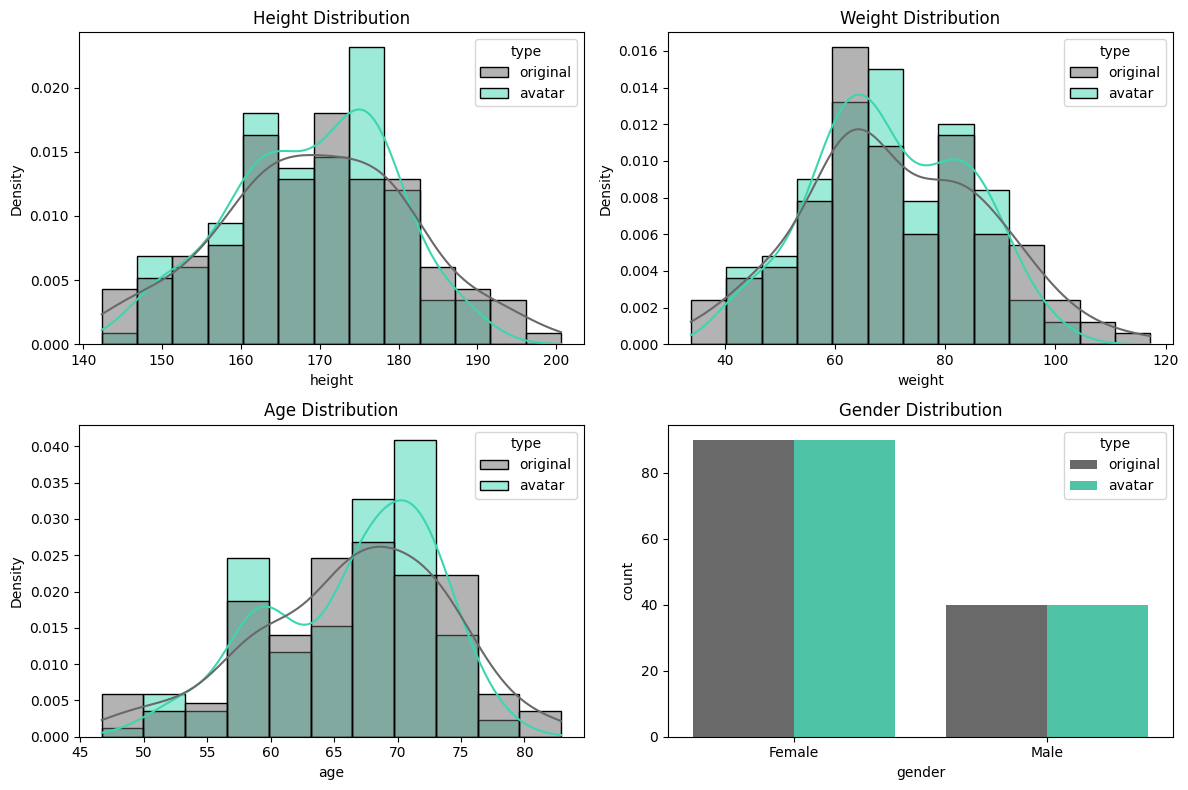

In [19]:
AVATAR_COLOR = '#3BD6B0'
ORIGINAL_COLOR = 'dimgrey'
map_color= {'original':ORIGINAL_COLOR, 'avatar':AVATAR_COLOR}

patient_combined = pd.concat([patient, patient_avatar]).reset_index(drop=True)
patient_combined['type'] = np.repeat(['original', 'avatar'], len(patient))

# Continuous distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(data=patient_combined, x='height', hue="type", palette=map_color, kde=True, ax=axes[0, 0], stat="density")
sns.histplot(data=patient_combined, x='weight', hue="type", palette=map_color, kde=True, ax=axes[0, 1], stat="density")
sns.histplot(data=patient_combined, x='age', hue="type", palette=map_color, kde=True, ax=axes[1, 0], stat="density")

# Categorical distribution
sns.countplot(data=patient_combined, x='gender',hue='type',  palette=map_color, ax=axes[1, 1])

axes[0, 0].set_title('Height Distribution')
axes[0, 1].set_title('Weight Distribution')
axes[1, 0].set_title('Age Distribution')
axes[1, 1].set_title('Gender Distribution')
plt.tight_layout()
plt.show()

### Doctor

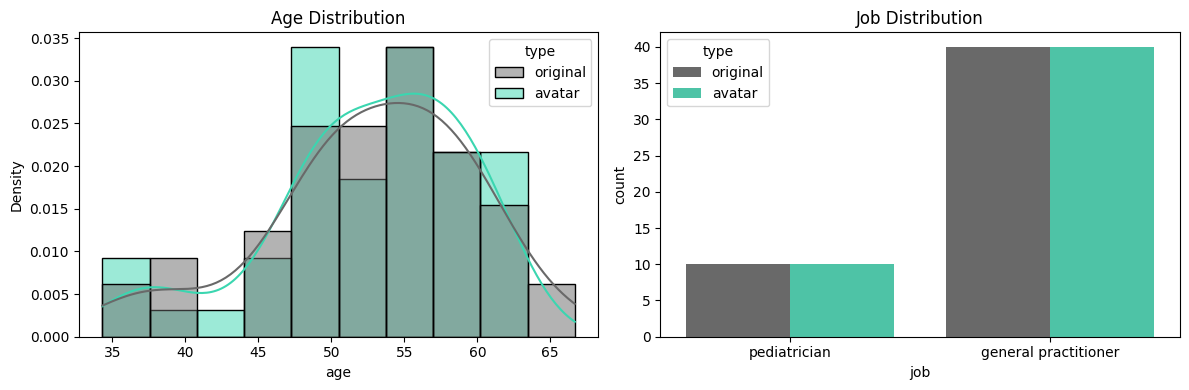

In [20]:
doctor_combined = pd.concat([doctor, doctor_avatar]).reset_index(drop=True)
doctor_combined['type'] = np.repeat(['original', 'avatar'], len(doctor))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Continuous distribution
sns.histplot(data=doctor_combined, x='age', hue="type", palette=map_color, kde=True, ax=axes[0], stat="density")

# Categorical distribution
sns.countplot(data=doctor_combined, x='job',hue='type',  palette=map_color, ax=axes[1])

axes[0].set_title('Age Distribution')
axes[1].set_title('Job Distribution')
plt.tight_layout()
plt.show()

### Visit

<Axes: xlabel='exam', ylabel='count'>

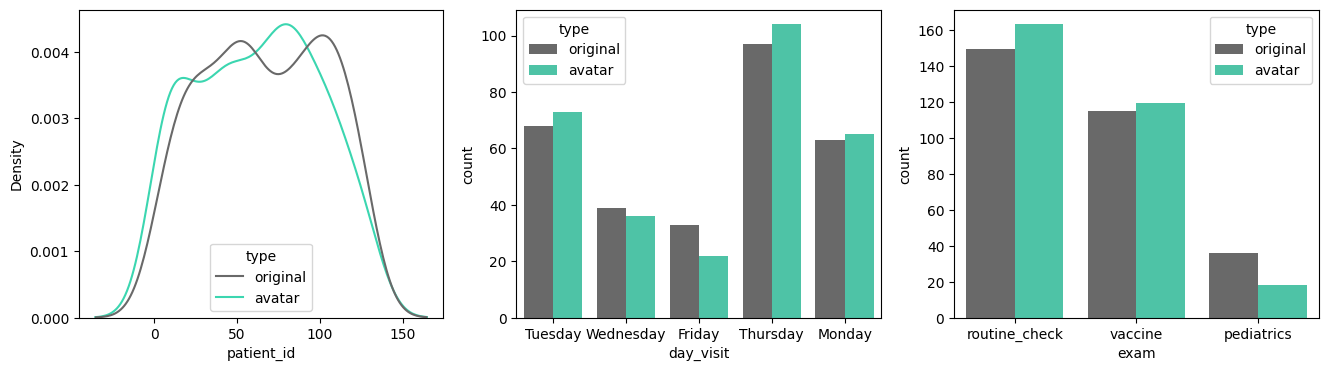

In [22]:
visit_combined = pd.concat([visit, visit_avatar]).reset_index(drop=True)
visit_combined['type'] = np.repeat(['original', 'avatar'], len(visit))

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
sns.kdeplot(data=visit_combined, x='patient_id', hue="type", ax=axes[0], palette=map_color)
day_order=list(visit['day_visit'].unique())
visit_combined['day_visit'] = pd.Categorical(visit_combined['day_visit'], categories=day_order, ordered=True)
visit_combined=visit_combined.sort_values('day_visit')
sns.countplot(data=visit_combined, x='day_visit',hue='type',  palette=map_color, ax=axes[1])
sns.countplot(data=visit_combined, x='exam',hue='type',  palette=map_color, ax=axes[2])


## Multivariate comparison 


### Visit x Patient

In [23]:
doctor_avatar_renamed = doctor_avatar.rename(columns={"age": "age_doctor"})
visit_avatar_flat = visit_avatar.join(
        doctor_avatar_renamed.set_index("d_id"), on="doctor_id"
    )
visit_avatar_flat = visit_avatar_flat.join(
        patient_avatar.set_index("p_id"), on="patient_id"
    )


doctor_renamed = doctor.rename(columns={"age": "age_doctor"})
visit_flat = visit.join(
        doctor_renamed.set_index("d_id"), on="doctor_id"
    )
visit_flat = visit_flat.join(
        patient.set_index("p_id"), on="patient_id"
    )



Text(0.5, 1.0, 'Avatar')

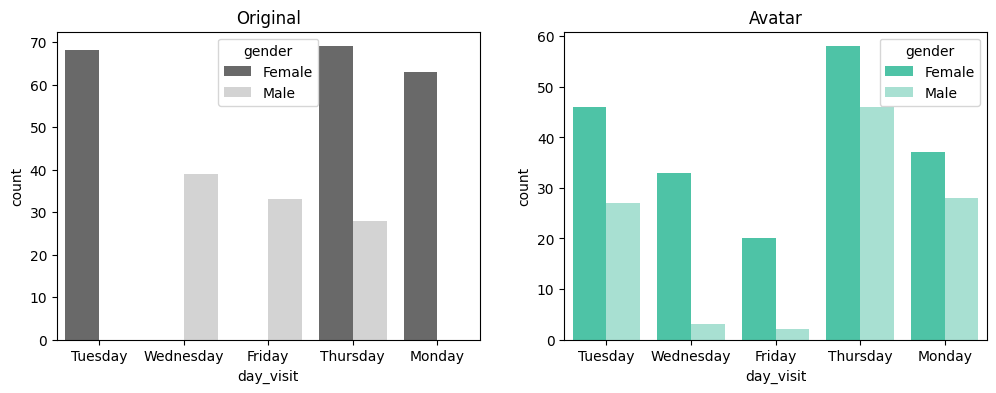

In [24]:
visit_flat['day_visit'] = pd.Categorical(visit_flat['day_visit'], categories=day_order, ordered=True)
visit_flat=visit_flat.sort_values('day_visit')
visit_avatar_flat['day_visit'] = pd.Categorical(visit_avatar_flat['day_visit'], categories=day_order, ordered=True)
visit_avatar_flat=visit_avatar_flat.sort_values('day_visit')
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(data=visit_flat,x='day_visit',hue="gender",ax=axes[0],palette=[ORIGINAL_COLOR, 'lightgrey'])
sns.countplot(data=visit_avatar_flat,x='day_visit',hue="gender",ax=axes[1],palette=[AVATAR_COLOR, '#9fe9d7'])
axes[0].set_title('Original')
axes[1].set_title('Avatar')

### Visit x Doctor

Text(0.5, 1.0, 'Avatar')

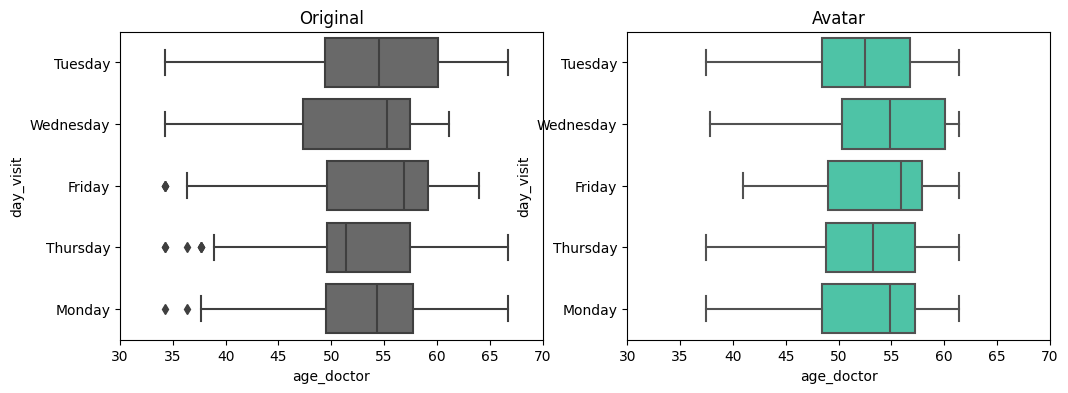

In [25]:
visit_flat['day_visit'] = pd.Categorical(visit_flat['day_visit'], categories=day_order, ordered=True)
visit_flat=visit_flat.sort_values(['day_visit','exam'])
visit_avatar_flat['day_visit'] = pd.Categorical(visit_avatar_flat['day_visit'], categories=day_order, ordered=True)
visit_avatar_flat=visit_avatar_flat.sort_values(['day_visit','exam'])
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(data=visit_flat,x='age_doctor',y='day_visit',ax=axes[0],palette=[ORIGINAL_COLOR])
sns.boxplot(data=visit_avatar_flat,x='age_doctor',y='day_visit',ax=axes[1],palette=[AVATAR_COLOR])
axes[0].set_xlim(30, 70)
axes[1].set_xlim(30, 70)
axes[0].set_title('Original')
axes[1].set_title('Avatar')

Text(0.5, 1.0, 'Avatar')

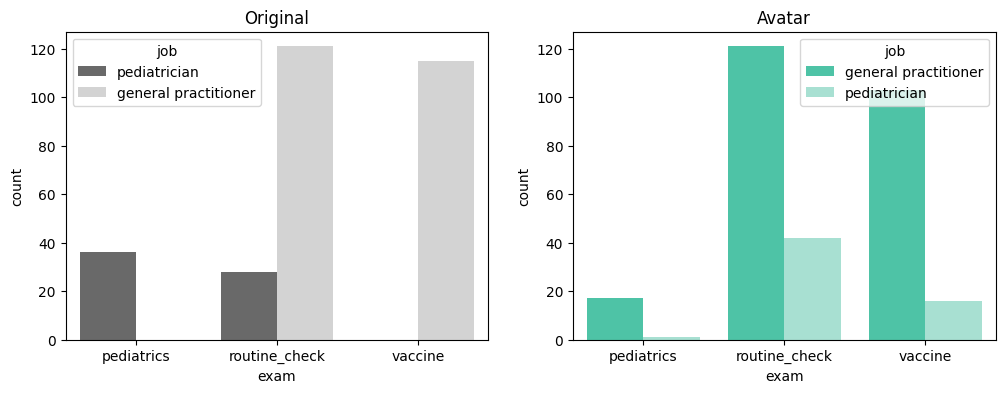

In [26]:
visit_avatar_flat=visit_avatar_flat.sort_values('exam')
visit_flat=visit_flat.sort_values('exam')
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(data=visit_flat,x='exam',hue="job",ax=axes[0],palette=[ORIGINAL_COLOR, 'lightgrey'])
sns.countplot(data=visit_avatar_flat,x='exam',hue="job",ax=axes[1],palette=[AVATAR_COLOR, '#9fe9d7'])
axes[0].set_title('Original')
axes[1].set_title('Avatar')

### Patient x Doctor

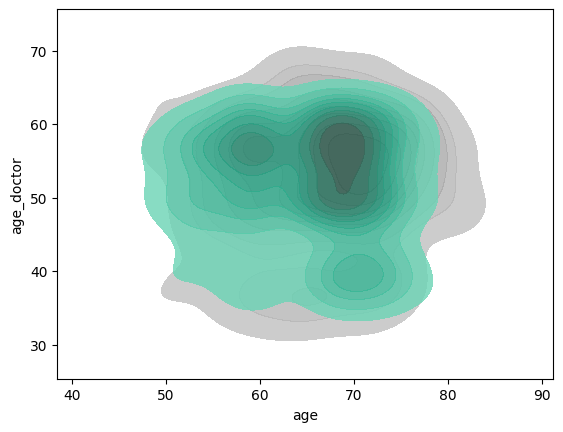

In [27]:
sns.kdeplot(data=visit_flat, x='age', y='age_doctor', fill=True,color=ORIGINAL_COLOR,alpha=0.8)
sns.kdeplot(data=visit_avatar_flat, x='age', y='age_doctor', fill=True,color=AVATAR_COLOR,alpha=0.8)
plt.show()
